# Opacities

This notebook shows how to create/read our **current** set of opacities. 

**Part 1** creates the opacities (this part will be updated), and **part 2** reads the created opacities (this part should stay the same). Both parts have their own `import` statements so that people without the tools to create the opacities could still use part 2 for reading in the resulting opacity files.

We now create the opacities in a transparent (open-source) way. In the near future, the opacities will be averaged over a narrow size distribution within each bin, to avoid resonance issues.

--------------------------------
## Part 1: Creating the opacities

### Procedure

The opacity is created in the following way, following [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403):

| Optical constants                                                                | Volume fractions [%] | material density [g/cm^3] |
|:---------------------------------------------------------------------------------|---------------------:|--------------------------:|
| Astronomical Silicates: [Draine 2003](https://dx.doi.org/10.1086/379123)         |           7          |            3.50           |
| Carbon  grains: [Zubko et al. 1996](https://dx.doi.org/10.1093/mnras/282.4.1321) |          21          |            2.50           |
| Water ice: [Warren & Brandt 2008](https://dx.doi.org/10.1029/2007JD009744)       |          42          |            1.00           |
| Vacuum                                                                           |          30          |            0.00           |

The mixing of the optical constants is done according to the Bruggeman mixing rule and the opacities are calculated using a Bohren & Huffman Mie code, more specifically a Fortran 90 translation of [Bruce Draines `bhmie.f`](https://www.astro.princeton.edu/~draine/scattering.html) code.

### The Code

The large program opacity package is now part of `DISKLAB`. To install the Large Program Opacity package `lp_opac` you can download code from [github](https://github.com/dullemond/DISKLAB) once it's made public, change into that directory, and install the package with the command

    pip install -e .
    
Until then, you can use the copy in `p484/projects/opacity/disklab`.

In [1]:
import numpy as np
from disklab import opacity

In [2]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

res = opacity.get_opacities(a, lam, return_all=True, extrapol=True, extrapolate_large_grains=True)

k_abs = res['k_abs']
k_sca = res['k_sca']
g     = res['g_sca']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
rho_s = res['rho_s']

Note: wavelength range outside data. Extrapolation will be done but is uncertain.
Mie ... Done!


Store the data

In [3]:
np.savez_compressed('default_opacities', a=a, lam=lam, k_abs=k_abs.T, k_sca=k_sca.T, g=g)

--------------------------------
## Part 2: Reading in from default format

As we update part 1, the opacities might change slightly, but this part should stay the same.

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(['seaborn',{'figure.dpi':150}])

Loading the data

In [2]:
data = np.load('default_opacities.npz')

a = data['a']
lam = data['lam']
k_abs = data['k_abs']
k_sca = data['k_sca']
g = data['g']

As an example: plot the opacities of the smallest grains as function of wavelength:

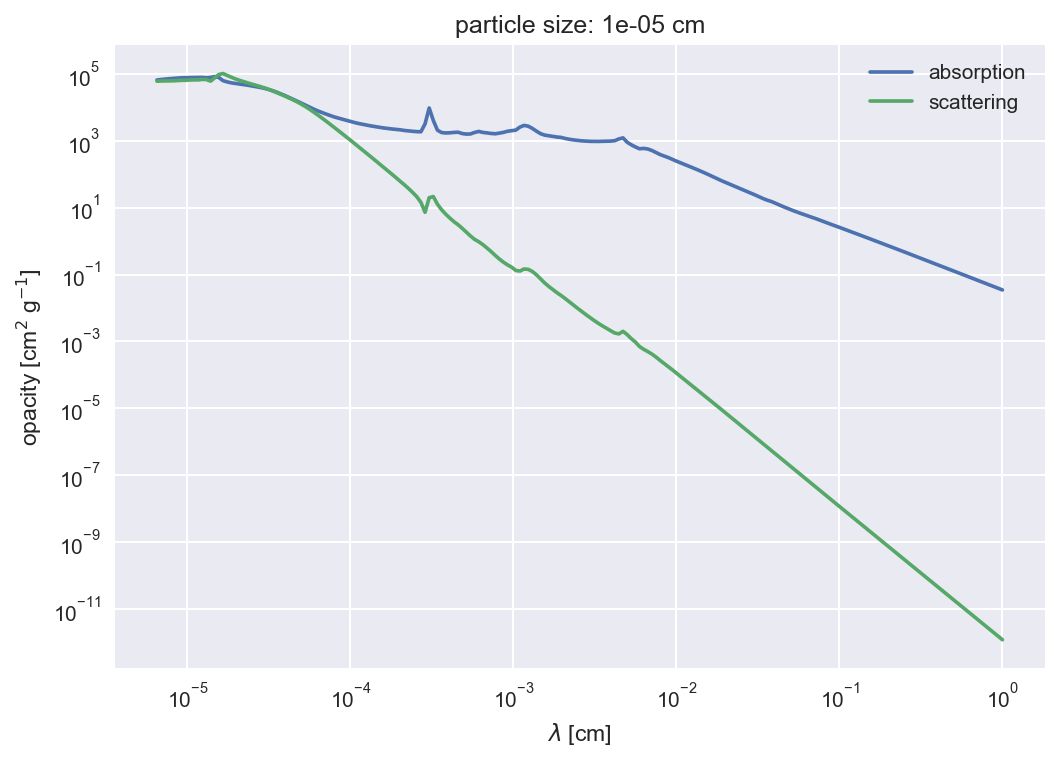

In [3]:
ia = 0
f, ax = plt.subplots()
ax.loglog(lam, k_abs[:, ia], label='absorption')
ax.loglog(lam, k_sca[:, ia], label='scattering')
ax.set_title(f'particle size: {a[ia]} cm')
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

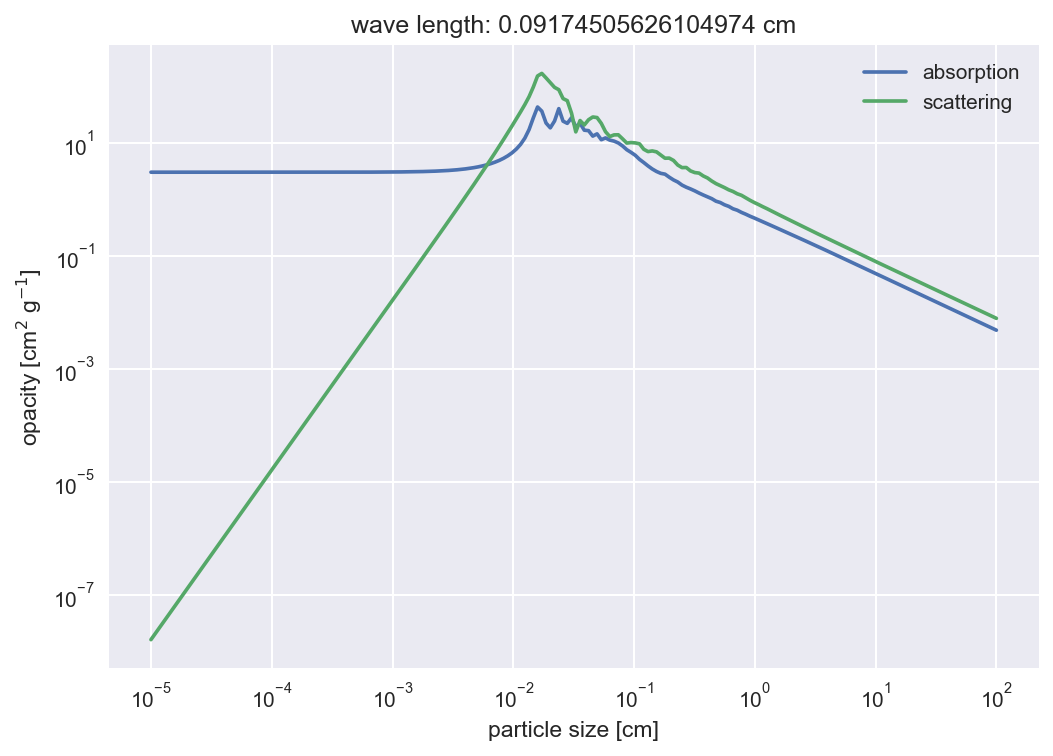

In [4]:
ilam = lam.searchsorted(0.088)
f, ax = plt.subplots()
ax.loglog(a, k_abs[ilam, :], label='absorption')
ax.loglog(a, k_sca[ilam, :], label='scattering')
ax.set_title('wave length: {} cm'.format(lam[ilam]))
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('particle size [cm]')
ax.legend();

-------------------------------- 
## Part 3

Comparison of size-averaged opacities to Luca Riccis data file.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from pkg_resources import resource_filename
plt.style.use(['seaborn',{'figure.dpi':150}])

from disklab import opacity

Load default opacity from file

In [2]:
data = np.load('default_opacities.npz')

a = data['a']
lam = data['lam']
k_abs = data['k_abs']
k_sca = data['k_sca']
g = data['g']

Load Lucas averaged opacity data.

In [3]:
datafile = resource_filename(opacity.__name__, os.path.join('optical_constants', 'testfiles_ricci', 'kappa.dat'))
luca = np.loadtxt(datafile)

Compare the averaged opacity curves

kappa_abs @ 1 mm for a_max = 1mm : 11.1 cm^2/g
kappa_abs @ 0.88 mm for a_max = 1mm : 12.9 cm^2/g


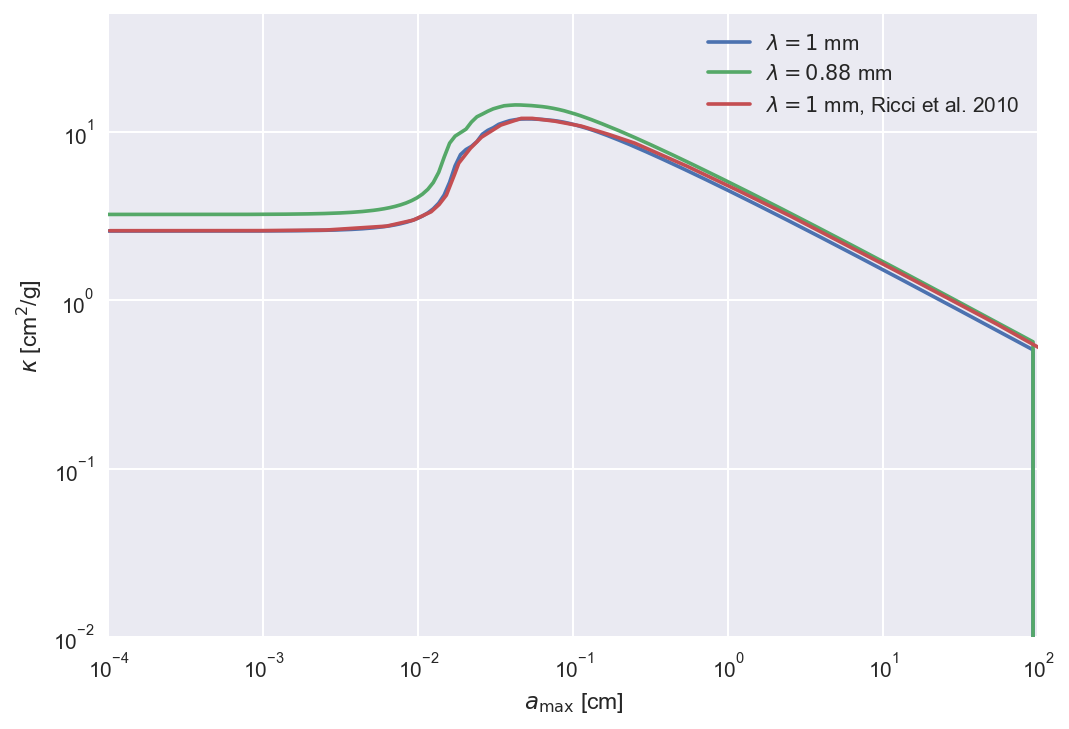

In [4]:
f, ax = plt.subplots()
for lam_avg in [0.1, 0.088]:
    
    # interpolate at the observed frequencies
    
    k_a = np.array([np.interp(lam_avg, lam, k_abs[:,ia]) for ia in range(len(a))])
    k_s = np.array([np.interp(lam_avg, lam, k_sca[:,ia]) for ia in range(len(a))])

    # average over size distributions
    
    k = np.zeros_like(a)
    for ia in range(len(a)-1):
        s = (a/a[0])**0.5
        s[ia+1:]=1e-100
        s = s/s.sum()
        k[ia] = np.sum(k_a*s)
        
    ax.loglog(a,k, label='$\lambda = {:2.2g}$ mm'.format(lam_avg*10))
    
    print('kappa_abs @ {:.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(lam_avg*10, np.interp(0.1, a, k)))
    
ax.set_xlabel('$a_\mathrm{max}$ [cm]')
ax.set_ylabel('$\kappa$ [cm$^2$/g]')
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(0.01, 50)

ax.loglog(luca[:,0], luca[:,1], label='$\lambda = 1$ mm, Ricci et al. 2010')
ax.legend()
f.savefig('opac.pdf')